In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab.utils.logging import ListLogger
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from tqdm import tqdm


from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import torch

from typing import Tuple, Optional
import torch
from functorch import vmap


from functools import partial


import torchsde
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable


from torchdiffeq import odeint
from torch.func import jacrev

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [6]:
def get_senders_and_receivers_fully_connected(n_nodes):
    receivers = []
    senders = []
    for i in range(n_nodes):
        for j in range(n_nodes - 1):
            receivers.append(i)
            senders.append((i + 1 + j) % n_nodes)
    return torch.tensor(senders), torch.tensor(receivers)

def energy(x, epsilon= 1.0, tau= 1.0, r= 1.0, harmonic_potential_coef= 0.5):
    n_nodes, dim = x.shape
    
    if isinstance(r, float):
        r = torch.ones(n_nodes, device=device) * r
    senders, receivers = get_senders_and_receivers_fully_connected(n_nodes)
    vectors = x[senders] - x[receivers]
    d = torch.linalg.norm(vectors, ord=2, dim=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * term_inside_sum.sum()

    centre_of_mass = x.mean(dim=0)
    harmonic_potential = harmonic_potential_coef * (x - centre_of_mass).pow(2).sum()
    return energy + harmonic_potential


def log_prob(x: torch.Tensor):
    x = x.reshape(-1, 13, 3)
    if len(x.shape) == 2:
        return - energy(x)
    elif len(x.shape) == 3:
        return - torch.vmap(energy)(x)
    else:
        raise Exception

In [7]:
def interatomic_dist(samples):
    # Compute the pairwise differences and distances
    dist = samples[:, None, :, :] - samples[:, :, None, :]
    differences = torch.linalg.norm(dist, dim=-1)
    return differences #torch.mean(differences, dim=(1, 2))

In [8]:
def plot_sample_hist(samples, ax = None, dim=(0,1), label=None):
    if ax == None:
        fig, ax = plt.subplots()
    d = interatomic_dist(samples)
    ax.hist(d, bins=50, density=True, alpha=0.4, label=label)

### Helper Functions

In [8]:
from abc import ABC, abstractmethod

class NoiseSchedule(ABC):
    @abstractmethod
    def g(t):
        # Returns g(t)
        pass
    
    @abstractmethod
    def h(t):
        # Returns \int_0^t g(t)^2 dt
        pass

    
class LinearNoiseSchedule(NoiseSchedule):
    def __init__(self, beta, norm_factor=1.0):
        self.beta = beta / norm_factor
        
    def g(self, t):
        return torch.sqrt(self.beta * 2 * t) #self.beta.sqrt()
    
    def h(self, t):
        return self.beta * t **2

class GeometricNoiseSchedule(NoiseSchedule):
    def __init__(self, sigma_min, sigma_max, norm_factor=1.0):
        self.sigma_min = sigma_min / norm_factor
        self.sigma_max = sigma_max / norm_factor
        self.sigma_diff = self.sigma_max / self.sigma_min
        
    def g(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then g(t) = sigma_min * sigma_d^t * sqrt{2 * log(sigma_d)}
        # See Eq 192 in https://arxiv.org/pdf/2206.00364.pdf
        return self.sigma_min * (self.sigma_diff ** t) * ((2 * np.log(self.sigma_diff)) ** 0.5)
        
    def h(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then h(t) = \int_0^t g(z)^2 dz = sigma_min * sqrt{sigma_d^{2t} - 1}
        # see Eq 199 in https://arxiv.org/pdf/2206.00364.pdf
        return (self.sigma_min * (((self.sigma_diff ** (2 * t)) - 1) ** 0.5)) ** 2

In [201]:
def clip(f, max_norm):
    norm = torch.linalg.vector_norm(f, dim=-1)
    clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
    f = f * clip_coef.unsqueeze(-1)
    return f

## Function Definitions

### Estimated Reward Functions

In [9]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, noise_schedule, num_mc_samples, var_exploding=True):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t)
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = log_prob(samples)
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = (repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) 
                   + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5))
        log_rewards = log_prob(samples)
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [10]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, randomness='different', 
                      in_dims=(0,0,None,None))(x, t, beta, num_mc_samples, var_exploding=var_exploding)

In [11]:
def estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100, var_exploding=True, richardson=False):
    est_scores_n = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples, var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples//2, var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

In [ ]:
def estimate_grad_Rt_jensen(x, t, noise_schedule, num_mc_samples=1000):
    repeated_x = x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    
    h_t = noise_schedule.h(repeated_t).unsqueeze(-1)
        
    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
    
    log_rewards = .log_prob(samples)#unnormalized_samples)
    gaussian_score = -(samples - repeated_x) / (h_t + 1e-6)
    
    return (log_rewards.unsqueeze(-1) * gaussian_score).mean(dim=0)

## SDE

### Dataset

In [12]:
beta = 5

n_nodes = 13
dim = 3

n_samples = 1024

In [13]:
centers = torch.zeros((n_samples, n_nodes*dim), device=device)
x1_samples = torch.normal(centers, torch.full_like(centers, fill_value=beta))

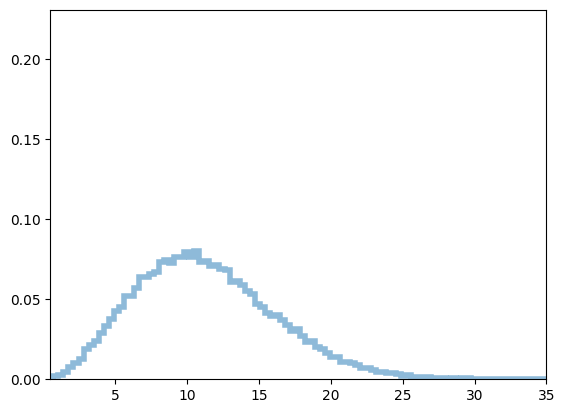

In [15]:
x1_dists = interatomic_dist(x1_samples.reshape(-1, n_nodes, dim))
plt.hist(x1_dists.view(-1).cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.xlim(0.5, 35)
plt.show()

In [18]:
# np load
# samples_all = np.load('all_data_LJ13.npy')
# samples_all = samples_all.reshape(-1, n_nodes, dim)
# samples_true = torch.tensor(samples_all[:1000], device=device)
# samples_all = sample_from_array(samples_all, n_samples)
# samples_true = torch.tensor(samples_all, device=device)
# del samples_all

In [16]:
def sample_from_array(array, size):
    idx = np.random.choice(array.shape[0], size=size)
    return array[idx]

In [20]:
samples_all = np.load('data/all_data_LJ13-2.npy')
test_data = samples_all[len(samples_all)//2:]
test_data = sample_from_array(test_data, 1000)
del samples_all
test_data = torch.tensor(test_data, device=device)

In [21]:
def remove_mean(samples, n_particles, n_dimensions):
    """
    Makes a configuration of many particle system mean-free.

    Parameters
    ----------
    samples : torch.Tensor
        Positions of n_particles in n_dimensions.

    Returns
    -------
    samples : torch.Tensor
        Mean-free positions of n_particles in n_dimensions.
    """

    shape = samples.shape
    if isinstance(samples, torch.Tensor):
        samples = samples.view(-1, n_particles, n_dimensions)
        samples = samples - torch.mean(samples, dim=1, keepdim=True)
        samples = samples.view(*shape)
    else:
        samples = samples.reshape(-1, n_particles, n_dimensions)
        samples = samples - samples.mean(axis=1, keepdims=True)
        samples = samples.reshape(*shape)
    return samples

In [22]:
# test_data = remove_mean(test_data, n_nodes, dim)

In [23]:
dist_test = interatomic_dist(test_data.reshape(-1, n_nodes, dim))
# dist_2 = interatomic_dist(samples_true)

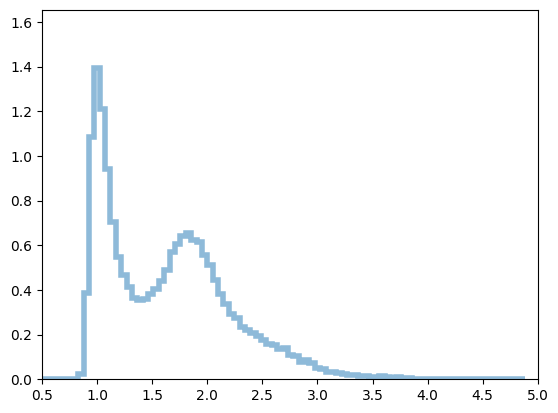

In [25]:
plt.hist(dist_test.view(-1).cpu(), bins=100, label="holdout samples", alpha=0.5, density=True, histtype='step', linewidth=4)
# plt.hist(dist_2.view(-1).cpu(), bins=100, label="true samples", alpha=0.5, density=True, histtype='step', linewidth=4)
plt.xlim(0.5, 5)
plt.show()

In [36]:
# plot_sample_hist(torch.tensor(samples_all, device=device).reshape(-1, n_nodes, dim).detach().cpu())
# plot_sample_hist(torch.tensor(samples_all_2, device=device).reshape(-1, n_nodes, dim).detach().cpu())
# del samples_all

### VE SDE

In [43]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule
    
    def f(self, t, x):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(device)

        x.requires_grad = True
        score = self.score(x, 1-t, self.noise_schedule)
        score = clip(score, max_norm=100)
        return self.g(t)**2 * score

    def g(self, t):
        return self.noise_schedule.g(t.unsqueeze(1))

In [44]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    
    drift = sde.f(t, x) * dt
    diffusion = sde.g(t) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    vectors = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            vectors.append(f)
    return torch.stack(samples)

## Training

### Dataset

In [170]:
from typing import NamedTuple, Optional, Union, Tuple
from pathlib import Path
class FullGraphSample(NamedTuple):
    positions: torch.Tensor
    features: torch.Tensor

    def __getitem__(self, i):
        return FullGraphSample(self.positions[i], self.features[i])


def positional_dataset_only_to_full_graph(positions) -> FullGraphSample:
    """Convert positional dataset into full graph by using zeros for features. Assumes data is only for x, and not
    augmented coordinates."""
    features = torch.zeros((*positions.shape[:-1], 1), dtype=int)
    return FullGraphSample(positions=positions, features=features)

In [171]:
sigma = np.sqrt(1.5)
beta = torch.tensor(sigma ** 2)
dim = 3
n_nodes = 13
n_samples = 512

noise_schedule = LinearNoiseSchedule(beta, norm_factor=1.0)

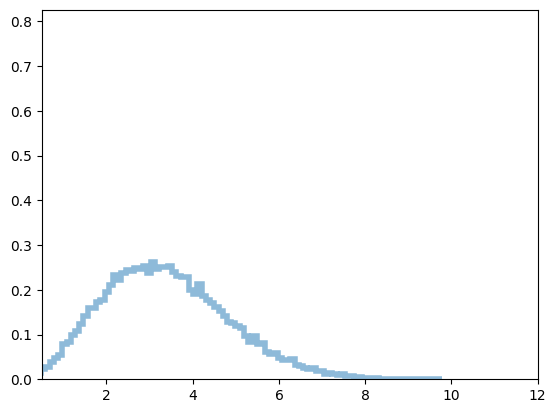

In [172]:
centers = torch.zeros((n_samples, n_nodes*dim), device=device)
x1_samples = torch.normal(centers, torch.full_like(centers, fill_value=beta))
x1_energy = log_prob(x1_samples.reshape(-1, n_nodes, dim))
x1_dists = interatomic_dist(x1_samples.reshape(-1, n_nodes, dim))
plt.hist(x1_dists.view(-1).cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.xlim(0.5, 12)
plt.show()

### Model

In [173]:
class VEReverseSDE(torch.nn.Module):

    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule
    
    def f(self, t, x):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(device)

        x.requires_grad = True
        score = self.score((1-t).unsqueeze(-1), x)
        norm = torch.linalg.vector_norm(score, dim=-1)
        max_norm = 100
        clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
        return self.g(t)**2 * score * clip_coef[:,None]

    def g(self, t):
        return self.noise_schedule.g(t.unsqueeze(1))

In [174]:
from egnn_pytorch import EGNN_Network
class EGNN_Wrapper(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net = EGNN_Network(
            *args, **kwargs
        )

    def forward(self, x, t, *args, **kwargs):
        is_flat = x.shape[-1] != 3
        if is_flat:
            x = x.reshape(-1, 13, 3)
        if t.dim() == 0:
            t = t[None].repeat(x.shape[0])
        if t.shape[0] != x.shape[0] and t.shape[0] == 1:
            t = t.repeat(x.shape[0])
        t_discrete = torch.bucketize(t, boundaries = torch.linspace(0, 1, 101).to(device))
        t_discrete = t_discrete[:, None].repeat(1, 13) #
        x = x - x.mean(dim=-2, keepdims=True)
        feats, coords = self.net(t_discrete, x)
        # coords = coords / coords.mean(dim=-2, keepdims=True)
        if is_flat:
            coords = coords.reshape(-1, 39)
        
        return coords

### Training

In [175]:
def reward_matching_loss_biased(vectorfield, x, t, noise_schedule, weighted=False):     
    h_t = noise_schedule.h(t.unsqueeze(1))
    
    x.requires_grad = True

    # noisy sample: x(t)
    noisy_x = torch.normal(x, h_t ** 0.5)
    pred_scores = vectorfield(t.unsqueeze(-1), noisy_x)

    estimated_scores = torch.vmap(estimate_grad_Rt, in_dims=(0,0,None), randomness="different")(noisy_x, t, noise_schedule)
    estimated_scores = clip(estimated_scores, max_norm=50)
    estimated_scores = estimated_scores

    if weighted:
        lambda_t = 1/(h_t + 1e-3)
        err = torch.linalg.vector_norm((estimated_scores - pred_scores), dim=-1)**2
        return (lambda_t * err).mean()
    else:
        return ((estimated_scores - pred_scores)**2).mean()

In [176]:
from models.egnn import EGNN_dynamics

In [177]:
# vectorfield(torch.tensor([0.5]).unsqueeze(0).repeat(512, 1).to(device), x1_samples.to(device)).shape

In [178]:
buffer = SimpleBuffer(n_nodes*dim, 10000, 1000, initial_sampler=None, 
                      device=device, fill_buffer_during_init=False, sample_with_replacement=True)

buffer.add(x1_samples, x1_energy)

Buffer not initialised, expected that checkpoint will be loaded.


In [179]:
sigma = np.sqrt(1.5)
beta = torch.tensor(sigma ** 2)
dim = 3
n_nodes = 13
n_samples = 512

noise_schedule = LinearNoiseSchedule(beta, norm_factor=1.0)

In [180]:
outer_epochs= 100
inner_epochs = 100

batch_size = 512

train_dataset = TensorDataset(x1_samples.clone(), x1_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

In [181]:
vectorfield = EGNN_dynamics(n_particles=n_nodes, device=device,  n_dimension=dim, hidden_nf=32,
    act_fn=torch.nn.SiLU(), n_layers=3, recurrent=True, tanh=True, attention=True, condition_time=True, agg='sum')

opt_vectorfield = Adam(vectorfield.parameters(), lr=1e-3)
weighted = True

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 38.196438
Epoch 49 | Loss 36.146141
Epoch 98 | Loss 35.090096


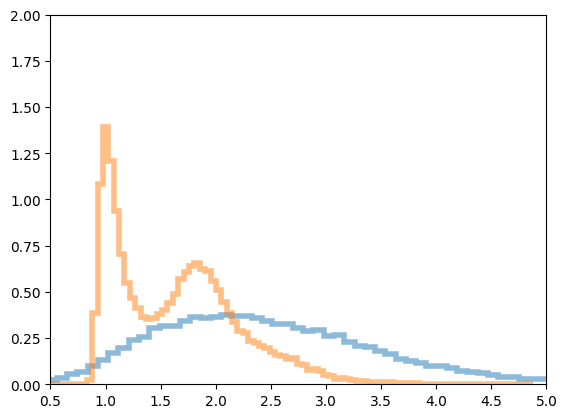

  1%|          | 1/100 [00:10<17:32, 10.63s/it]

Epoch 0 | Loss 49.680328
Epoch 49 | Loss 37.899841
Epoch 98 | Loss 34.213242


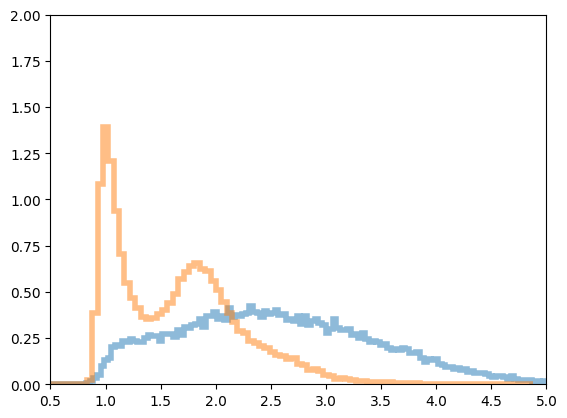

  2%|▏         | 2/100 [01:16<1:10:23, 43.10s/it]

Epoch 0 | Loss 33.005199
Epoch 49 | Loss 29.127110
Epoch 98 | Loss 36.005367


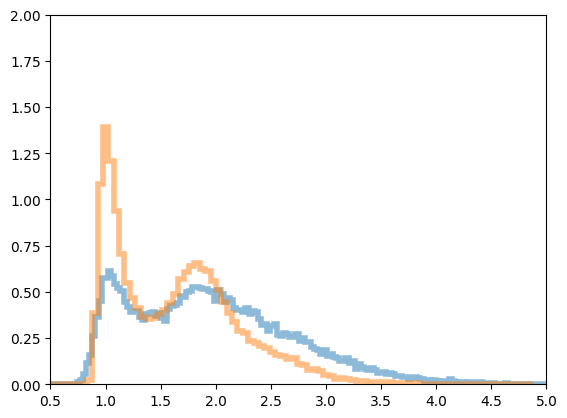

  3%|▎         | 3/100 [02:22<1:26:22, 53.43s/it]

Epoch 0 | Loss 36.986347
Epoch 49 | Loss 40.426178
Epoch 98 | Loss 41.087601


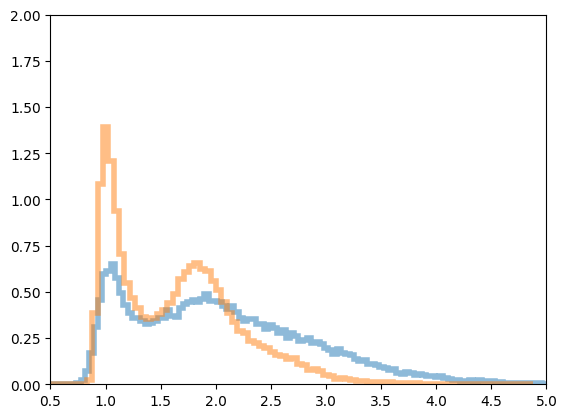

  4%|▍         | 4/100 [03:27<1:33:16, 58.30s/it]

Epoch 0 | Loss 44.380646
Epoch 49 | Loss 43.023415
Epoch 98 | Loss 43.735764


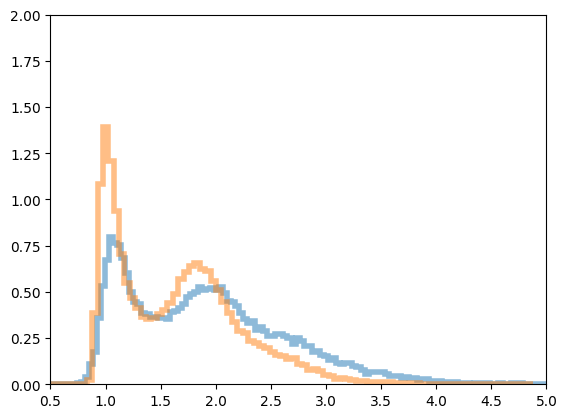

  5%|▌         | 5/100 [04:33<1:36:27, 60.92s/it]

Epoch 0 | Loss 44.900723
Epoch 49 | Loss 50.324703
Epoch 98 | Loss 48.472424


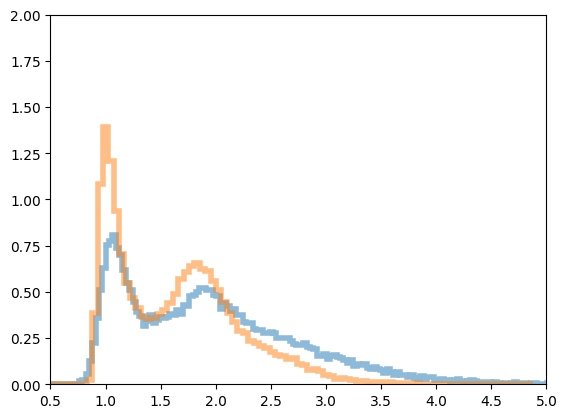

  6%|▌         | 6/100 [05:39<1:38:14, 62.70s/it]

Epoch 0 | Loss 54.083279
Epoch 49 | Loss 52.841003
Epoch 98 | Loss 47.374245


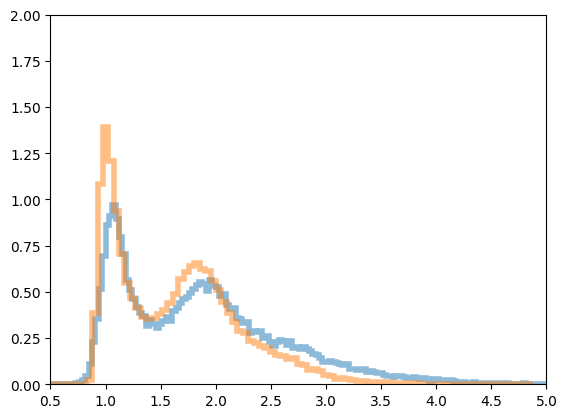

  7%|▋         | 7/100 [06:45<1:38:40, 63.66s/it]

Epoch 0 | Loss 61.546436
Epoch 49 | Loss 56.839169
Epoch 98 | Loss 56.712276


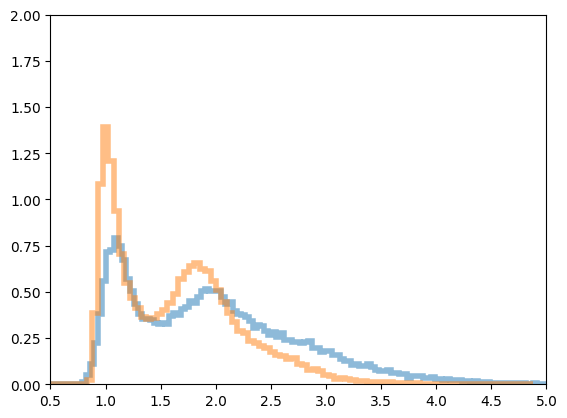

  8%|▊         | 8/100 [07:50<1:38:27, 64.21s/it]

Epoch 0 | Loss 54.563210
Epoch 49 | Loss 55.539864
Epoch 98 | Loss 51.503914


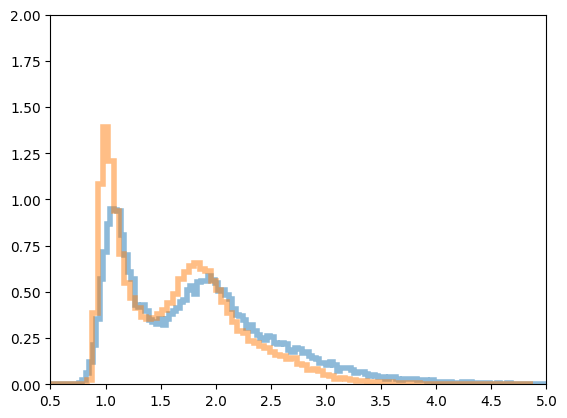

  9%|▉         | 9/100 [08:56<1:37:55, 64.57s/it]

Epoch 0 | Loss 66.927322
Epoch 49 | Loss 57.470455
Epoch 98 | Loss 64.158882


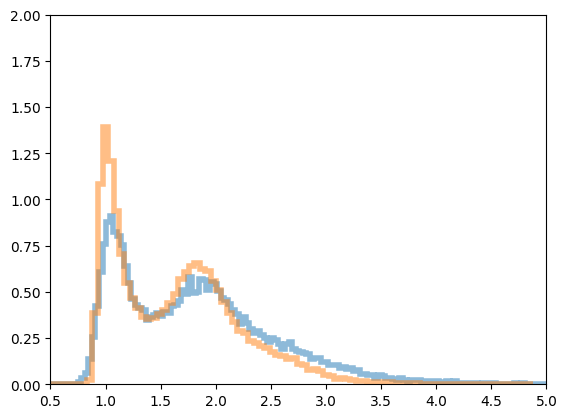

 10%|█         | 10/100 [10:01<1:37:20, 64.89s/it]

Epoch 0 | Loss 54.714901
Epoch 49 | Loss 56.269394
Epoch 98 | Loss 61.090214


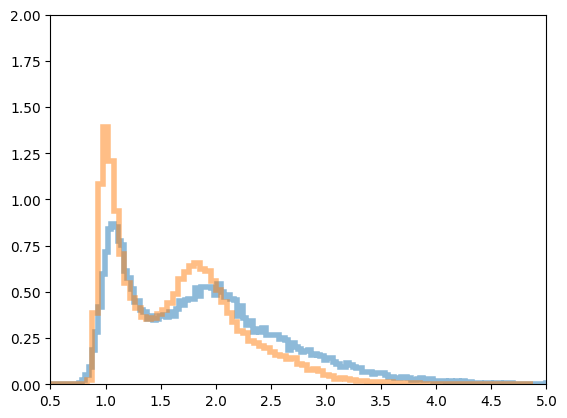

 11%|█         | 11/100 [11:07<1:36:37, 65.14s/it]

Epoch 0 | Loss 59.714054
Epoch 49 | Loss 55.162521
Epoch 98 | Loss 59.989307


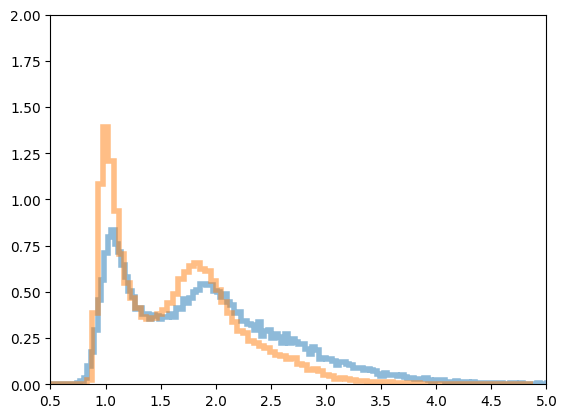

 12%|█▏        | 12/100 [12:13<1:35:55, 65.40s/it]

Epoch 0 | Loss 58.428856
Epoch 49 | Loss 60.439354
Epoch 98 | Loss 64.475060


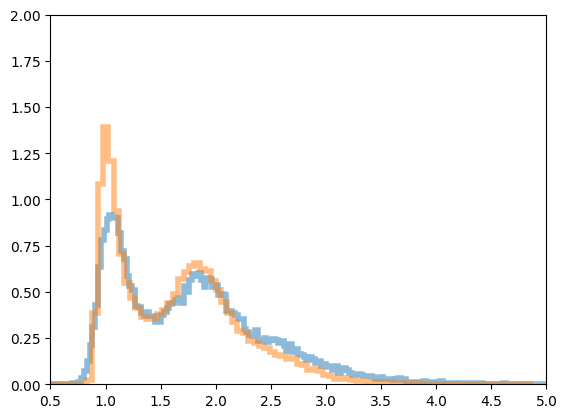

 13%|█▎        | 13/100 [13:18<1:34:54, 65.45s/it]

Epoch 0 | Loss 70.802521
Epoch 49 | Loss 62.249744
Epoch 98 | Loss 63.338879


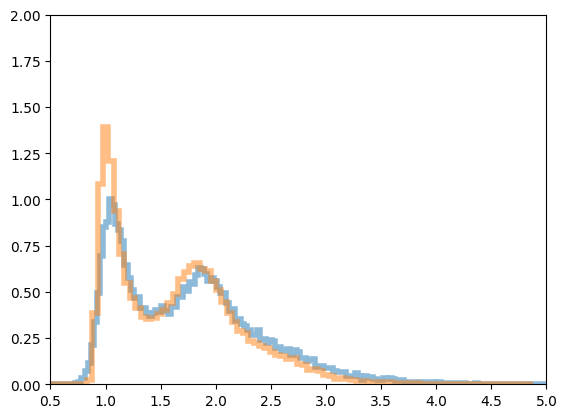

 14%|█▍        | 14/100 [14:24<1:33:45, 65.41s/it]

Epoch 0 | Loss 58.597984
Epoch 49 | Loss 60.660213
Epoch 98 | Loss 65.307770


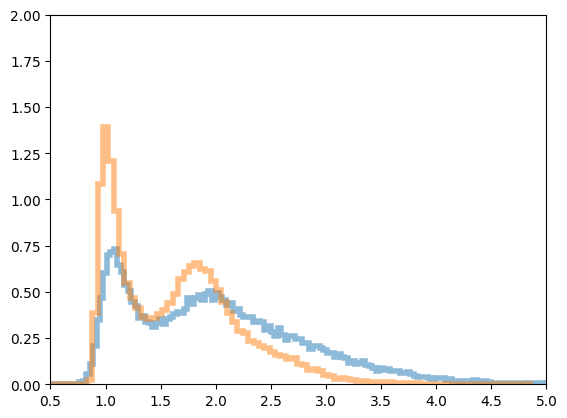

 15%|█▌        | 15/100 [15:29<1:32:24, 65.22s/it]

Epoch 0 | Loss 68.781937
Epoch 49 | Loss 68.379120
Epoch 98 | Loss 65.643494


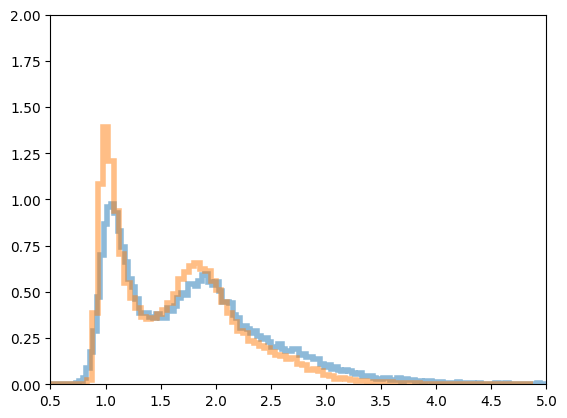

 16%|█▌        | 16/100 [16:34<1:31:35, 65.42s/it]

Epoch 0 | Loss 60.134102
Epoch 49 | Loss 66.021355
Epoch 98 | Loss 66.360619


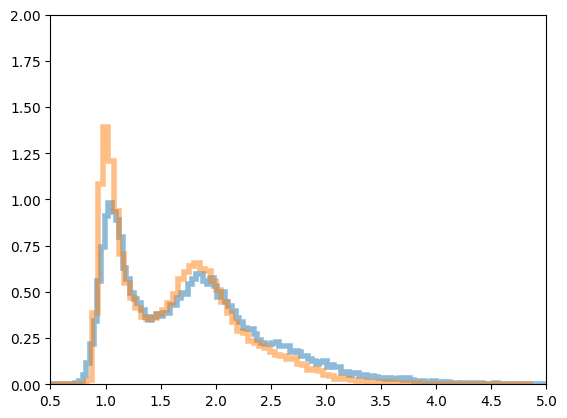

 17%|█▋        | 17/100 [17:40<1:30:24, 65.35s/it]

Epoch 0 | Loss 71.596230
Epoch 49 | Loss 66.253914
Epoch 98 | Loss 71.698769


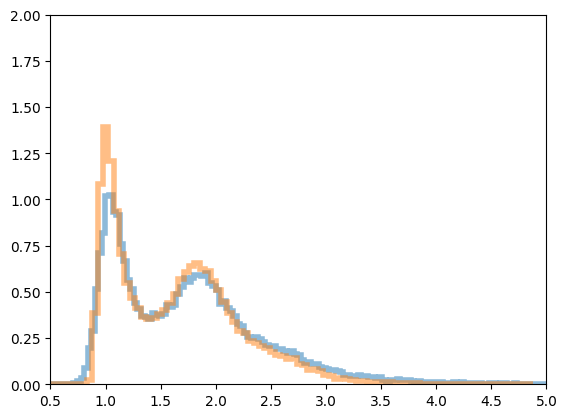

 18%|█▊        | 18/100 [18:45<1:29:18, 65.35s/it]

Epoch 0 | Loss 74.850929
Epoch 49 | Loss 70.396957
Epoch 98 | Loss 70.104858


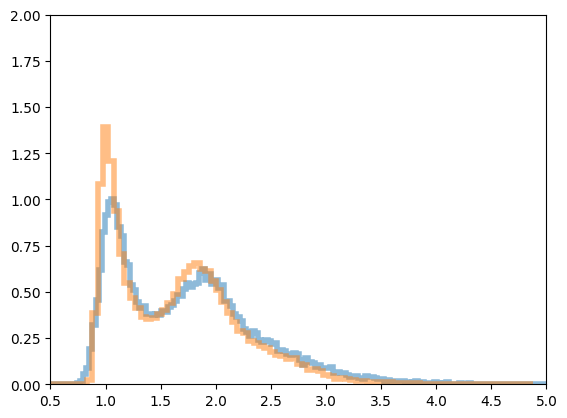

 19%|█▉        | 19/100 [19:50<1:28:13, 65.36s/it]

Epoch 0 | Loss 68.026520
Epoch 49 | Loss 79.850510
Epoch 98 | Loss 71.297234


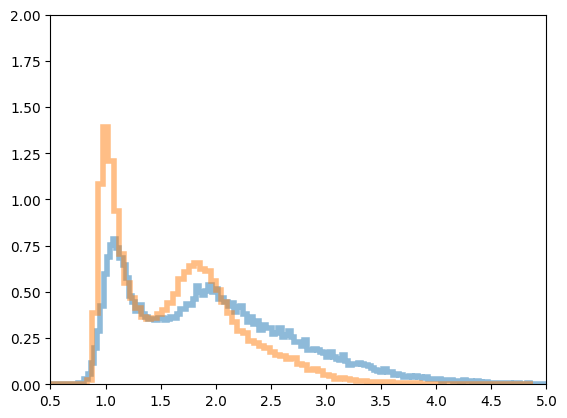

 20%|██        | 20/100 [20:56<1:27:08, 65.36s/it]

Epoch 0 | Loss 71.499451
Epoch 49 | Loss 72.755470
Epoch 98 | Loss 75.152084


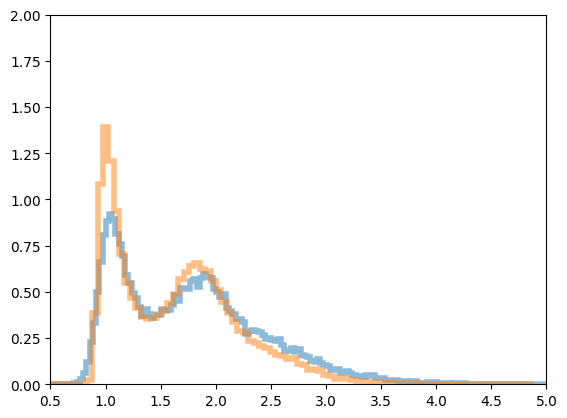

 21%|██        | 21/100 [22:01<1:26:03, 65.36s/it]

Epoch 0 | Loss 76.030510


 21%|██        | 21/100 [22:19<1:23:57, 63.77s/it]


KeyboardInterrupt: 

In [182]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            opt_vectorfield.zero_grad()
            
            t = torch.rand(len(samples), device=device)

            loss = reward_matching_loss_biased(vectorfield, samples, t, noise_schedule)
            total_loss += loss.item()
            loss.backward()
            opt_vectorfield.step()
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the vector field
    centers = torch.zeros((n_samples, n_nodes*dim), device=device)
    x1_samples = torch.normal(centers, torch.full_like(centers, fill_value=noise_schedule.h(1)**2))

    ve_reverse_sde = VEReverseSDE(vectorfield, noise_schedule)
    samples = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-3)[-1]
    samples_energy = log_prob(samples).detach()

    # Update Buffer 
    buffer.add(samples, samples_energy)

    dist_samples = interatomic_dist(samples.reshape(-1, n_nodes, dim))

    plt.hist(dist_samples.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, histtype='step', linewidth=4)
    plt.hist(dist_test.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4) 
    plt.xlim(0.5, 5)
    plt.ylim(0, 2)
    plt.show()

    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

### Evaluation

### NLL

In [287]:
follow_estimate = False
follow_model = True
reverse_time =  False

In [296]:
def prior_dist(beta):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(n_nodes*dim).to(device), torch.eye(n_nodes*dim).to(device) * beta
    )
    return dist

In [297]:
def drift(x, t):
    with torch.enable_grad():
        x.requires_grad = True

        if follow_estimate:
            f = estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100)
            f = clip(f, max_norm=100)
            f = -0.5 * noise_schedule.g(t)**2 * f

        else:
            f = vectorfield(t.unsqueeze(-1), x)
            # f = clip(f, max_norm=100)
            f = - 0.5 * noise_schedule.g(t)[0]**2 * f

    return f

In [298]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    if follow_model:
        def div(x):
            return torch.trace(J(x.unsqueeze(0)).squeeze())
        return div
    else:
        return lambda x: torch.trace(J(x))


def output_and_div(vecfield, x):
    if follow_estimate:
        dx = torch.vmap(vecfield, randomness="different")(x)
    else:
        dx = vecfield(x)
    
    if reverse_time:
        div = torch.zeros((x.shape[0]), device=device)
    else:
        div = torch.vmap(div_fn(vecfield), randomness="different")(x)
    return dx, div

In [300]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    
    vecfield = lambda x: drift(x, t)
    if follow_model:
        def vecfield(x):
            return drift(x, torch.ones(x.shape[0]).to(device) * t)
    
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)

with torch.no_grad():
    if reverse_time:
        x1 = torch.randn(1024, 39).to(device) * sigma
        time = torch.linspace(1, 0, 1000).to(device)
    else:
        x1 = test_data
        time = torch.linspace(0, 1, 100).to(device)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(odefunc, state1, t=time, method="euler")[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    p0 = prior_dist(beta)
    logp0 = p0.log_prob(x0)
    logp1 = -(logp0 + logdetjac)

In [301]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-47.5622, device='cuda:0')
logdetjac tensor(-15.4821, device='cuda:0')
logp1 tensor(63.0443, device='cuda:0')


In [302]:
x0_true = torch.randn((1000, n_nodes*dim), device=device) * np.sqrt(beta)
true_logp0 = p0.log_prob(x0_true.view(-1, 39))
print("true_logp0", true_logp0.mean())

true_logp0 tensor(-63.3848, device='cuda:0')


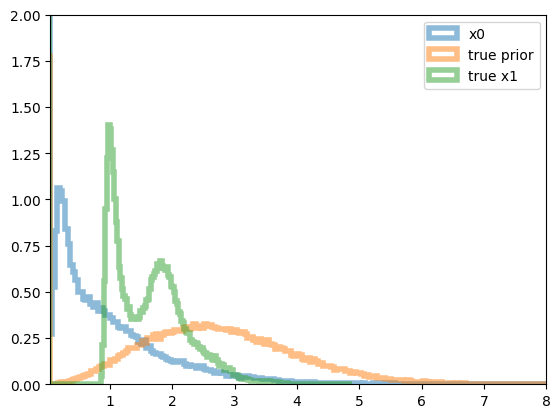

In [303]:
x0 = x0.reshape(-1, n_nodes, dim)
x0_dists = interatomic_dist(x0)
x0_true_dists = interatomic_dist(x0_true.reshape(-1, n_nodes, dim)).detach()
test_dists = interatomic_dist(test_data.reshape(-1, n_nodes, dim))

plt.hist(x0_dists.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, 
         histtype='step', linewidth=4, label='x0')
plt.hist(x0_true_dists.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4, label='true prior') 
plt.hist(test_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4, label='true x1')
plt.xlim(0.05, 8)
plt.ylim(0, 2.0)
plt.legend()
plt.show()